# Upwelling analysis

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import yaml
import os
import gsw
from contextlib import ExitStack
from cmocean import cm
from scipy import signal
from scipy.interpolate import interp1d
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools
from dynmodes import dynmodes

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 14

***

## Processing code

### Define variables and load reference datasets

In [3]:
# Load mask and bathymetry
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
grid_HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')

with open('parameters.yaml') as f: grids, _, events = yaml.safe_load_all(f)
    
params = {
    'u_wind': [5, 10, 15],
    'h_s': [10, 15, 20],
    'rho_s': [1016, 1018, 1020],
    'N': np.arange(0.01, 0.026, 0.0025),
}

const = {
    'g': 9.81, 'f': 1.11e-4, 'N': 0.01, 'h_s': 10, 'H': 50, 'L_r': 1e4, 't': 86400,
    'rho_0': 1025, 'rho_s': 1020, 'rho_air': 1.23, 'C_d': 1e-3,
}

mask_arrays = {}
for key in ['tmask', 'gdept_1d', 'gdepw_1d', 'e3t_1d', 'e1t', 'e2t']:
    mask_arrays[key] = mask[key][0, :].values

***

### Calculate coastline indices

In [4]:
def calc_coastline_indices(filter_window=5):
    """Find the NEMO-SalishSeaCast j, i pairs along the western coastline.                                      
    Also finds the coastline angle CW from north-south, and the average cross-                                  
    shore bottom slope between zero and 200 m depth. I would prefer this                                        
    routine to be flexible to various choices of jmin, jmax and jsub but in                                     
    reality it takes a bit of tuning to avoid errors.                                                           
    """

    # Mask out Gulf Islands
    tmask = mask.tmask[0, ...].values
    tmask[:, :450, :230] = 0
    
    # Indexing parameters
    imin, jmin, jmax, jsub = 115, 355, 730, 5
    jignore = [365, 370, 430, 460, 485, 490, 515, 595, 600, 615, 635, 640, 645, 650]
    
    # Create jindex
    jcoast = np.arange(jmin, jmax, jsub)
    jignore = np.array([j in jignore for j in jcoast])
    jcoast = jcoast[~jignore]
    
    # Build angle array (angles and ranges were chosen manually)
    jcut = [0, 360, 405, 425, 460, 555, 570, 600, 650, 695, 897]
    angles = [-0.55, -0.35, -0.2, -0.1, -0.6, -0.45, -0.25, -0.3, -0.25, -0.1]
    angle = np.zeros(len(jcoast))
    for j0, j1, a in zip(jcut[:-1], jcut[1:], angles):
        angle[(jcoast > j0) & (jcoast <= j1)] = a

    # Initialize index array                                                   
    icoast, iwind, jwind, slope = [], [], [], []

    # Iterate through jindex                                                                                    
    for j, a in zip(jcoast, angle):

        # Find i at coast                                                                    
        i, i_d = [np.where(abs(np.diff(tmask[z, j, imin:])) > 0)[0] for z in [0, 29]]                                                                  
        i = i[i < i_d[0]][-1] + imin
        
        # Define pointer variables
        e1t, e2t = [mask_arrays[key][j, i] for key in ['e1t', 'e2t']]
        
        # Define offshore sections
        d1, d2 = [const['L_r'] / dim for dim in [e1t, e2t]]
        i_s = np.linspace(i, i + np.cos(a) * d1, int(d1)).astype(int)
        j_s = np.linspace(j, j - np.sin(a) * d2, int(d2)).astype(int)
        
        # Find j, i of deep isobath (or slightly shallower if necessary) and slope
        index = np.array([float(bathy.Bathymetry[y, x]) for y, x in zip(j_s, i_s)]) > const['H']
        index = index.nonzero()[0][0]
        j_d, i_d = j_s[index], i_s[index]
        s = const['H'] / np.sqrt(((i_d - i) * e1t)**2 + ((j_d - j) * e2t)**2)
        
        # Search for nearest lon/lat neighbors
        j_w, i_w = geo_tools.find_closest_model_point(
            mask.glamt[0, j, i].values, mask.gphit[0, j, i].values,
            grid_HRDPS.longitude-360, grid_HRDPS.latitude,
            grid='GEM2.5', tols={'GEM2.5': {'tol_lon': 0.017, 'tol_lat': 0.017}},
        )
        
        # Append new values
        icoast.append(i)
        iwind.append(i_w)
        jwind.append(j_w)
        slope.append(s)

    # Populate sections dict
    window = signal.get_window('blackman', filter_window)
    w = int((filter_window - 1) / 2)
    subset = slice(w, -w)
    sections = {
        'ji': [jcoast[subset], np.array(icoast)[subset]],
        'ji_wind': [np.array(jwind)[subset], np.array(iwind)[subset]],
        'angle': np.array(angle)[subset], 'n': len(jcoast[subset]),
        'slope': signal.convolve(slope, window / sum(window), mode='same')[subset],
    }

    return sections

***

### Process results

Universal functions

In [5]:
def calc_rho(data, depth, tmask):
    """
    """

    # Calculate density
    tracers = ['vosaline', 'votemper']
    rho = gsw.rho(*[np.ma.masked_where(tmask == 0, data[key]) for key in tracers], depth)

    return rho


def calc_stratification_parameters(rho):
    """
    """
    
    # Define pointer variables
    deptht, depthw, e3t = [mask_arrays[key] for key in ['gdept_1d', 'gdepw_1d', 'e3t_1d']]

    # Find average N2 profile on deptht grid
    interp_rho = interp1d(deptht, rho, axis=0, fill_value='extrapolate')
    N2 = const['g'] / const['rho_0'] * np.diff(interp_rho(depthw), axis=0) / e3t[:-1, np.newaxis]
    nanindex = np.all(np.isnan(N2), axis=1)
    N2 = np.nanmedian(N2[~nanindex, :], axis=1)

    # Calculate pycnocline depth using vertical mode calculator dynmodes
    _, _, rmode, _ = dynmodes(N2, deptht[:-1][~nanindex], 1)
    z_s, z_b = int(abs(rmode[0, :]).argmax()), min(const['H'], np.where(nanindex)[0][0])
    h_s = deptht[z_s]
    rho_s = (np.nanmedian(rho[:z_s, :], axis=1) * e3t[:z_s]).sum() / depthw[z_s]
    N = (np.sqrt(N2[:z_b]) * e3t[:z_b]).sum() / depthw[z_b]

    return h_s, rho_s, N

Idealized result functions

In [12]:
def calc_idealized_metrics(runs, file, param, hour=24):
    """
    """
    
    # Define pointer variables and list storage
    deptht, tmask = [mask_arrays[key] for key in ['gdept_1d', 'tmask']]
    i_sub, _, j_sub, _ = grids['ideal']
    
    # Open results file
    with xr.open_dataset(file) as data:

        # Loop through sections
        for j, i, a in zip(*sections['ji'], sections['angle']):

            # Calculate rho at t0 and t1
            L, rho = int(const['L_r'] / mask_arrays['e1t'][j, i]), []
            for t, k, depth in zip([0, hour], [slice(None, None), 0], [deptht[:, np.newaxis], 0]):
                rho.append(calc_rho(
                    data.isel(time_counter=t, deptht=k, y=j-j_sub, x=slice(i-i_sub, i-i_sub+L)),
                    depth, tmask[k, j, i:i+L],
                ))

            # Calculate stratification parameters
            h_s, rho_s, N = calc_stratification_parameters(rho[0])
            
            # Calculate upwelling depth
            h_u = deptht[int(np.median(abs(rho[0] - rho[1].max()).argmin(axis=0)))]
            
            # Append params to run dict
            for key, var in zip(['h_u', 'h_s', 'rho_s', 'N'], [h_u, h_s, rho_s, N]): runs[key].append(var)

    # Append coastline arrays to runs output
    tau = param['U']**2 * const['rho_air'] * const['C_d']
    tau_along, tau_cross = [tau * getattr(np, func)(np.arctan(2) - sections['angle']) for func in ['sin', 'cos']]
    keys = ['j', 'angle', 'slope', 'tau_along', 'tau_cross']
    values = [sections['ji'][0], sections['angle'], sections['slope'], tau_along, tau_cross]
    for key, val in zip(keys, values): runs[key] = np.concatenate((runs[key], val))
        
    # Append run parameters to runs output
    #ones = np.ones(sections['n'])
    #for key in param:
    #    if key not in runs: runs[key] = np.empty(0)
    #    runs[key] = np.concatenate((runs[key], param[key] * ones))

    return runs


def load_idealized(
    config='2layer', hour=24,
    path='/data/bmoorema/results/Lake/S4d',
    fn='SalishSeaIdeal_1h_20170701_20170706_grid_T.nc',
):
    """                                                                                                     
    """
    
    # Initialize storage dict
    runs = {}
    for key in ['h_u', 'h_s', 'rho_s', 'N']: runs[key] = []
    for key in ['j', 'angle', 'slope', 'tau_along', 'tau_cross']: runs[key] = np.empty(0)
    
    # 2 layer config processing
    if config == '2layer':
        for h_s in params['h_s']:
            for rho_s in params['rho_s']:
                for U in params['u_wind']:
                    
                    # Define run params
                    param = {'h_s': h_s, 'rho_s': rho_s, 'U': U, 'N': const['N']}
                    
                    # Build filename
                    runstr = f'SalishSeaPond_S4d{U:02d}ms_halocline{h_s}m_rhosurf{rho_s}'
                    file = os.path.join(f'{path}_{config}', runstr, fn)
                    
                    # Append upwelling diagnostics
                    if os.path.exists(file):
                        runs = calc_idealized_metrics(runs, file, param, hour=hour)
    
    # Constant N config processing
    elif config == 'Nconst':
        for N in params['N']:
            for U in params['u_wind']:
                
                # Define run params
                param = {'h_s': const['h_s'], 'rho_s': const['rho_s'], 'U': U, 'N': N}

                # Build filename
                runstr = f'SalishSeaPond_S4d{U:02d}ms_N{N*1e4:04.0f}s'
                file = os.path.join(f'{path}_{config}', runstr, fn)

                # Append upwelling diagnostics
                if os.path.exists(file):
                    runs = calc_idealized_metrics(runs, file, param, hour=hour)
    
    # Convert lists to arrays
    for key in ['h_u', 'h_s', 'rho_s', 'N']: runs[key] = np.array(runs[key])
                    
    return runs

Hindcast result functions

In [13]:
def make_prefix(date, path, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object                                                                                                      
    and paths dict. e.g.,                                                                                                                                                           
    /results/SalishSea/hindcast.201812/ddmmmyy/SalishSea_1h_yyyymmdd_yyyymmdd                                                                                                       
    """

    datestr = '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))
    prefix = os.path.join(
        path, date.strftime('%d%b%y').lower(), f'SalishSea_1{res}_{datestr}',
    )

    return prefix


def load_wind(dates, hour=24):
    """
    """
    
    # Offshore lengthscale
    L = int(const['L_r'] / 2.5e3)
    
    # Initiate lists
    tau_along, tau_cross = [], []
    
    # Loop through dates
    for date in tqdm(dates):
        
        # Parse date
        daterange = [parse(date) + timedelta(hours=h) for h in [0, hour]]
        
        # Loop through sections
        for j, i, a in zip(*sections['ji_wind'], sections['angle']):
    
            # Calculate tau                                                                                                                                             
            u, v = [
                HRDPS[k].sel(time=slice(*daterange)).isel(gridY=j, gridX=slice(i, i+L)).values
                for k in ['u_wind', 'v_wind']
            ]
            tau = 1.225e-3 * (np.sqrt(u**2 + v**2)**2)
            angle = np.arctan2(v, u) - np.pi * (29 / 180) + a
            tau_along.append((tau * np.sin(angle)).mean(axis=0).mean())
            tau_cross.append((tau * np.cos(angle)).mean(axis=0).mean())
    
    # Return wind stress as dict of arrays
    runs = {'tau_along': np.array(tau_along), 'tau_cross': np.array(tau_cross)}
    
    return runs


def load_hindcast(
    dates, hour=24,
    path='/results2/SalishSea/hindcast.201905',
):
    """
    """
    
    # Define pointer variables and initialize dict storage
    deptht, tmask = [mask_arrays[key] for key in ['gdept_1d', 'tmask']]
    runs = {}
    for key in ['j', 'angle', 'slope']: runs[key] = np.empty(0)
    for key in ['h_u', 'h_s', 'rho_s', 'N']: runs[key] = []
    
    # Loop through dates
    for date in dates:
        
        # Append coastline parameters to runs dict
        keys = ['j', 'angle', 'slope']
        values = [sections['ji'][0], sections['angle'], sections['slope']]
        for key, val in zip(keys, values):
            runs[key] = np.concatenate((runs[key], val))
        
        # Open results files
        timerange = [parse(date) + timedelta(hours=h) for h in [0, hour]]
        files = [make_prefix(t, path, res='h') + '_grid_T.nc' for t in timerange]
        with ExitStack() as stack:
            data = [stack.enter_context(xr.open_dataset(file)) for file in files]

            # Loop through sections
            for j, i, a in zip(*sections['ji'], sections['angle']):
                
                # Calculate rho at t0 and t1
                L, rho = int(const['L_r'] / mask_arrays['e1t'][j, i]), []
                for ds, t, k, depth in zip(data, timerange, [slice(None, None), 0], [deptht[:, np.newaxis], 0]):
                    rho.append(calc_rho(
                        ds.sel(time_counter=t, method='nearest').isel(deptht=k, y=j, x=slice(i, i+L)),
                        depth, tmask[k, j, i:i+L],
                    ))

                # Calculate stratification parameters
                h_s, rho_s, N = calc_stratification_parameters(rho[0])
                
                # Calculate upwelling depth
                h_u = deptht[int(np.median(abs(rho[0] - rho[1].max()).argmin(axis=0)))]

                # Append params to run dict
                for key, var in zip(['h_u', 'h_s', 'rho_s', 'N'], [h_u, h_s, rho_s, N]): runs[key].append(var)

    # Convert to numpy arrays
    for key in ['h_u', 'h_s', 'rho_s', 'N']: runs[key] = np.array(runs[key])
    
    return runs

***

## Analysis

Process HRDPS results

In [20]:
const['H'] = 20
sections = calc_coastline_indices()
runs_wind = load_wind(events)
runs_idealized = load_idealized()
runs_hindcast = load_hindcast(events)

/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


***

### Effect of lower layer depth

In [16]:
def plot_results(ax, config='idealized', H=50, lim=5):
    """
    """
    
    # Update H and run results
    const['H'] = H
    sections = calc_coastline_indices()
    if config == 'idealized':
        runs = load_idealized()
        tau = runs['tau_along']
    elif config == 'hindcast':
        runs = load_hindcast(events)
        tau = runs_wind['tau_along']

    # Calculate surface metrics
    c_s = np.sqrt(const['g'] * (const['rho_0'] - runs['rho_s']) / const['rho_0'] * runs['h_s'])
    hu_s = tau * const['t'] / (const['rho_0'] * c_s * runs['h_s'])
    
    # Calculate deep metrics
    S = runs['slope'] * runs['N'] / const['f']
    T_d = const['rho_0'] * runs['N'] * const['H']**2 / tau
    exp = 1 - np.exp(-2 * np.arctan(S) * const['t'] / T_d)
    hu_d = const['H'] / runs['h_s'] * np.arccos(1 - 2 * S**2 / (1 + S**2) * exp) / (2 * np.arctan(S))

    # Plot results
    for h_u, color, label in zip([hu_s, hu_d], ['r', 'k'], ['2 layer', 'Constant $N$']):
        ax.plot(h_u, runs['h_u']/runs['h_s'], 'o', color=color, label=label)

    # Formatting
    ax.plot([0, lim], [0, lim], 'k--')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])
    ax.set_xlabel('$h_u/h_s$ (predicted)')
    ax.set_title(f'$H$ = {H} m')

**Idealized**

/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater


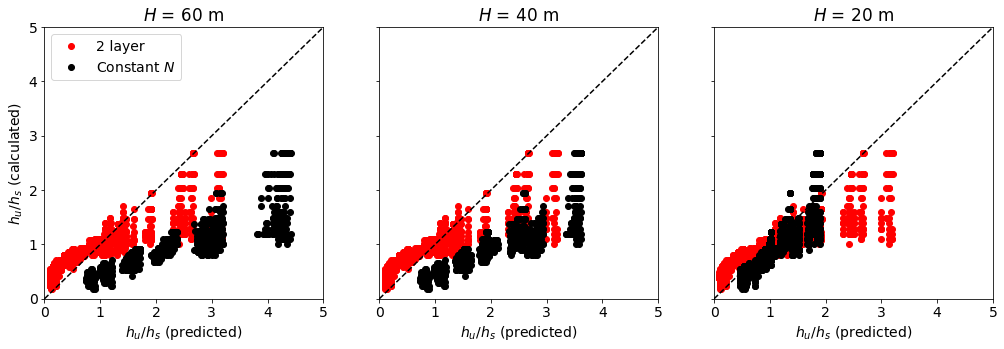

In [14]:
# Plot idealized results
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

# Loop through H
for ax, H in zip(tqdm(axs), [60, 40, 20]):
    
    # Plot results
    plot_results(ax, config='idealized', H=H, lim=5)
    
    if H == 60: ax.set_ylabel('$h_u/h_s$ (calculated)')
    else: ax.yaxis.set_ticklabels('')
        
axs[0].legend()
plt.show()

**Hindcast**

/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in arccos
/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in arccos
/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater
/home/bmoorema/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in arccos


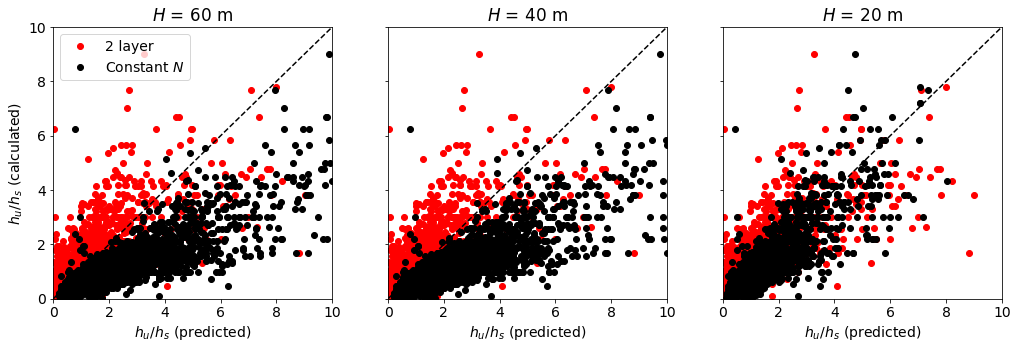

In [18]:
# Plot hindcast results
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

# Loop through H
for ax, H in zip(tqdm(axs), [60, 40, 20]):
    
    # Plot results
    plot_results(ax, config='hindcast', H=H, lim=10)
    
    if H == 60: ax.set_ylabel('$h_u/h_s$ (calculated)')
    else: ax.yaxis.set_ticklabels('')
        
axs[0].legend()
plt.show()

***

### Alongshore variability (2 layer only)

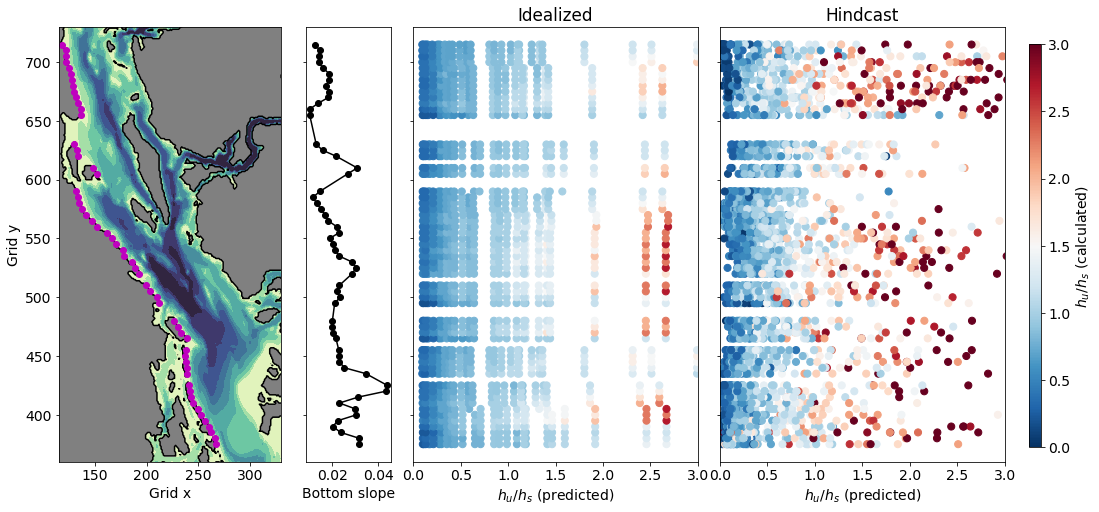

In [72]:
# Make figure panels
fig, axs = plt.subplots(1, 4, figsize=(17, 8), gridspec_kw={'width_ratios': [0.8, 0.3, 1, 1], 'wspace': 0.1})

# Plot map and bathymetry
axs[0].contourf(mask_arrays['tmask'][0, ...], levels=[-0.01, 0.01], colors='gray')
axs[0].contour(mask_arrays['tmask'][0, ...], levels=[-0.01, 0.01], colors='k')
axs[0].contourf(bathy.Bathymetry, levels=range(0, 500, 50), cmap=cm.deep)
axs[0].plot(*sections['ji'][::-1], 'mo')
axs[0].set_xlim([115, 330])
axs[0].set_ylim([360, 730])
axs[0].set_xlabel('Grid x')
axs[0].set_ylabel('Grid y')
viz_tools.set_aspect(axs[0])

# Plot bottom slope
axs[1].plot(sections['slope'], sections['ji'][0], 'ko-')
axs[1].set_ylim([0, 0.05])
axs[1].set_ylim([360, 730])
axs[1].set_xlabel('Bottom slope')
axs[1].yaxis.set_ticklabels('')

# Plot upwelling diagnostics
for ax, runs, title in zip(axs[2:], [runs_idealized, runs_hindcast], ['Idealized', 'Hindcast']):
    if 'tau_along' in runs: tau = runs['tau_along']
    else: tau = runs_wind['tau_along']
    c_s = np.sqrt(const['g'] * (const['rho_0'] - runs['rho_s']) / const['rho_0'] * runs['h_s'])
    hu_s = tau * const['t'] / (const['rho_0'] * c_s * runs['h_s'])
    c = ax.scatter(hu_s, runs['j'], s=50, c=runs['h_u'] / runs['h_s'], vmin=0, vmax=3, cmap='RdBu_r')
    ax.set_xlim([0, 3])
    ax.set_ylim([360, 730])
    ax.set_xlabel('$h_u/h_s$ (predicted)')
    ax.set_title(title)
    ax.yaxis.set_ticklabels('')

# Add colorbar
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='$h_u/h_s$ (calculated)')
plt.show()

***

### Slope dependence (2 layer only)

Scatter plot by Burger number

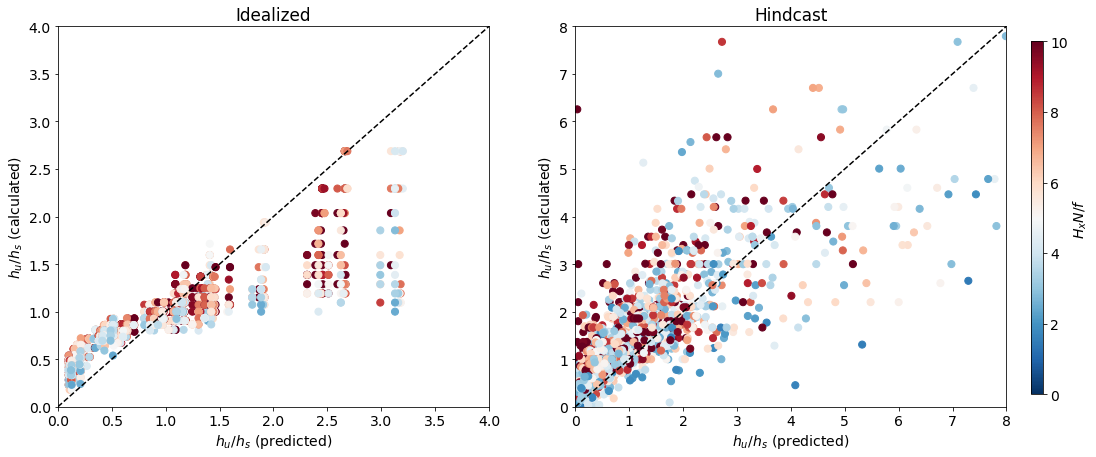

In [87]:
# Make panels
fig, axs = plt.subplots(1, 2, figsize=(17, 7))

# Plot upwelling diagnostics
for ax, runs, title, lim in zip(axs, [runs_idealized, runs_hindcast], ['Idealized', 'Hindcast'], [4, 8]):
    if 'tau_along' in runs: tau = runs['tau_along']
    else: tau = runs_wind['tau_along']

    # Calculate surface metrics
    c_s = np.sqrt(const['g'] * (const['rho_0'] - runs['rho_s']) / const['rho_0'] * runs['h_s'])
    hu_s = tau * const['t'] / (const['rho_0'] * c_s * runs['h_s'])
    S = runs['slope'] * runs['N'] / const['f']

    # Plot results
    c = ax.scatter(hu_s, runs['h_u']/runs['h_s'], s=50, c=S, cmap='RdBu_r', vmin=0, vmax=10)

    # Formatting
    ax.plot([0, lim], [0, lim], 'k--')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])
    ax.set_xlabel('$h_u/h_s$ (predicted)')
    ax.set_ylabel('$h_u/h_s$ (calculated)')
    ax.set_title(title)
    
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='$H_xN/f$')
plt.show()

Bin by Burger number

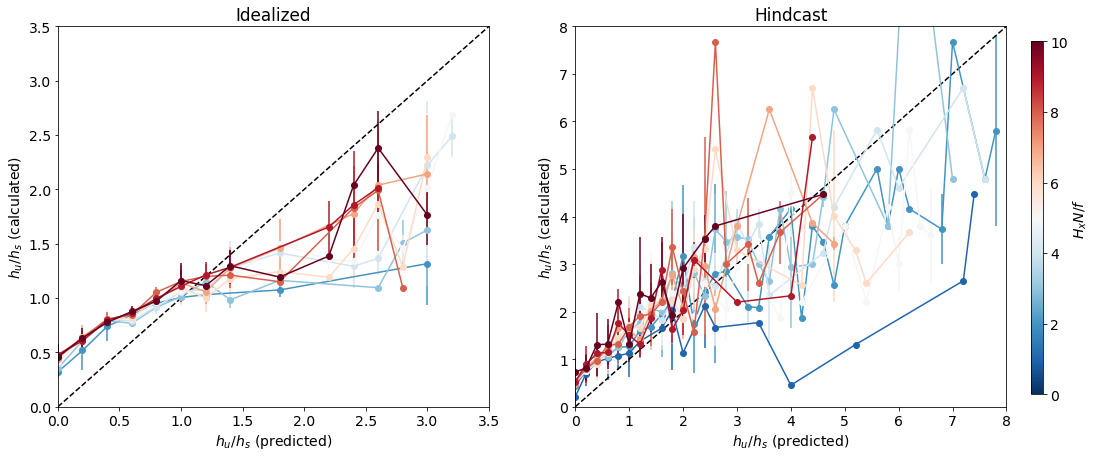

In [115]:
# Make panels
fig, axs = plt.subplots(1, 2, figsize=(17, 7))
cmap = plt.get_cmap('RdBu_r')

# Plot upwelling diagnostics
for ax, runs, title, lim in zip(axs, [runs_idealized, runs_hindcast], ['Idealized', 'Hindcast'], [3.5, 8]):
    if 'tau_along' in runs: tau = runs['tau_along']
    else: tau = runs_wind['tau_along']

    # Calculate surface metrics
    c_s = np.sqrt(const['g'] * (const['rho_0'] - runs['rho_s']) / const['rho_0'] * runs['h_s'])
    hu_s = tau * const['t'] / (const['rho_0'] * c_s * runs['h_s'])
    S = runs['slope'] * runs['N'] / const['f']

    # Plot results
    for s in range(0, 11, 1):
        hu, mean, std = [], [], []
        for h in np.arange(0, lim, 0.2):
            
            index = (S > s) & (S < s + 1) & (hu_s > h) & (hu_s < h + 0.2)
            if any(index):
                hu.append(h)
                mean.append((runs['h_u']/runs['h_s'])[index].mean())
                std.append((runs['h_u']/runs['h_s'])[index].std())
        
        ax.errorbar(hu, mean, yerr=std, marker='o', color=cmap(s/10))

    # Formatting
    ax.plot([0, lim], [0, lim], 'k--')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])
    ax.set_xlabel('$h_u/h_s$ (predicted)')
    ax.set_ylabel('$h_u/h_s$ (calculated)')
    ax.set_title(title)
    
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=10), cmap=cmap), cax=cax, label='$H_xN/f$')
plt.show()